In [1]:
import os
import glob
import pickle as pkl
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, cross_validate, cross_val_predict
from sklearn.metrics import r2_score, \
    explained_variance_score, normalized_mutual_info_score, mutual_info_score, make_scorer, mean_absolute_error
from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.utils import shuffle
from sklearn.base import BaseEstimator, RegressorMixin

from skll.metrics import spearman, pearson

from xgboost import XGBRegressor, XGBClassifier
from xgboost import plot_importance

from pylab import rcParams
rcParams['figure.figsize'] = 10,12

In [2]:
from dairyml import *

# Import the Data
Load the data from the pickle files created in `preproccess.ipynb`

In [3]:
with open("../pkl/data/data_outliers_removed", "rb" ) as f:
    [X, Y] = pkl.load(f)

## Modelling with XGB

### Setup

In [4]:
splitter= RepeatedKFold(n_splits=10,n_repeats=5)

In [5]:
scoring = {'r2':make_scorer(r2_score), 
           'SRC':make_scorer(spearman), 
           'PCC':make_scorer(pearson), 
           'MI':make_scorer(mutual_info_score), 
           'MAE':make_scorer(mean_absolute_error)}

In [6]:
try:
    overall_results = pd.read_csv('../reports/model_results.csv',index_col=0)
except FileNotFoundError:
    overall_results = pd.DataFrame(columns = scoring.keys())

### Regressor only

The search space below is the final step after some hand tuning, the code for which is not currently shown.

In [7]:
param_grid = {'max_depth': [9], 'n_estimators': [50,100,150], 'colsample_bytree': [0.9]}
refit = 'r2'

search = GridSearchCV(estimator=XGBRegressor(),param_grid=param_grid,scoring=scoring,refit=refit,cv=splitter)
fitted = search.fit(X,Y)

C:\Users\Gabriel\AppData\Local\conda\conda\envs\DairyML\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [8]:
overall_results = scores_to_df(overall_results,'XGB Regressor',search.cv_results_,refit)
overall_results

C:\Users\Gabriel\AppData\Local\conda\conda\envs\DairyML\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_r2'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Gabriel\AppData\Local\conda\conda\envs\DairyML\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_SRC'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Gabriel\AppData\Local\conda\conda\envs\DairyML\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_PCC'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*w

,train_r2,train_SRC,train_PCC,train_MI,train_MAE,test_r2,test_SRC,test_PCC,test_MI,test_MAE,test_accuracy,train_accuracy,test_recall,train_recall
Dummy Mean,0.00,0.00,0.00,-0.00,1.93,-0.02,0.00,-0.00,-0.00,1.94,NaN,NaN,NaN,NaN
Dummy Median All,-0.29,0.00,-0.00,-0.00,1.68,-0.32,0.00,-0.00,-0.00,1.68,NaN,NaN,NaN,NaN
Dummy Median Nonzero,-0.06,0.00,-0.00,-0.00,1.77,-0.08,0.00,-0.00,-0.00,1.77,NaN,NaN,NaN,NaN
"Perfect Clasif., Mean Regr.",0.13,0.73,0.40,0.54,1.53,0.13,0.73,0.41,0.53,1.53,NaN,NaN,NaN,NaN
Lasso,0.59,0.67,0.78,4.42,1.10,0.45,0.61,0.70,3.07,1.23,NaN,NaN,NaN,NaN
Bounded Lasso,0.66,0.69,0.82,4.04,0.97,0.55,0.64,0.75,2.87,1.08,NaN,NaN,NaN,NaN
Logistic Regression Classifier,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.89,1.0,0.95,1.0
Bounded Lasso + LogReg,0.74,0.89,0.87,3.93,0.74,0.64,0.80,0.82,2.66,0.86,NaN,NaN,NaN,NaN
Ridge,0.56,0.66,0.76,4.42,1.12,0.42,0.60,0.69,3.07,1.23,NaN,NaN,NaN,NaN
Bounded Ridge,0.65,0.70,0.82,4.05,0.97,0.53,0.63,0.74,2.82,1.10,NaN,NaN,NaN,NaN


In [9]:
model = fitted.best_estimator_
with open("../models/xgb_regressor.model", "wb" ) as f:
    pkl.dump(model,f)

### Classifier only

In [10]:
Y_binary = (Y != 0)
Y_binary = Y_binary.astype(int)

In [11]:
param_grid = {'max_depth': [7, 9, 11]}

search= GridSearchCV(estimator=XGBClassifier(),param_grid=param_grid,scoring=('accuracy','recall'),refit='accuracy',cv=splitter)
fitted = search.fit(X,Y_binary)

In [12]:
search.best_score_

0.9689008042895443

In [13]:
overall_results = scores_to_df(overall_results,'XGB Classifier',search.cv_results_,refit='accuracy')
overall_results

C:\Users\Gabriel\AppData\Local\conda\conda\envs\DairyML\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_accuracy'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Gabriel\AppData\Local\conda\conda\envs\DairyML\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_recall'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


,train_r2,train_SRC,train_PCC,train_MI,train_MAE,test_r2,test_SRC,test_PCC,test_MI,test_MAE,test_accuracy,train_accuracy,test_recall,train_recall
Dummy Mean,0.00,0.00,0.00,-0.00,1.93,-0.02,0.00,-0.00,-0.00,1.94,NaN,NaN,NaN,NaN
Dummy Median All,-0.29,0.00,-0.00,-0.00,1.68,-0.32,0.00,-0.00,-0.00,1.68,NaN,NaN,NaN,NaN
Dummy Median Nonzero,-0.06,0.00,-0.00,-0.00,1.77,-0.08,0.00,-0.00,-0.00,1.77,NaN,NaN,NaN,NaN
"Perfect Clasif., Mean Regr.",0.13,0.73,0.40,0.54,1.53,0.13,0.73,0.41,0.53,1.53,NaN,NaN,NaN,NaN
Lasso,0.59,0.67,0.78,4.42,1.10,0.45,0.61,0.70,3.07,1.23,NaN,NaN,NaN,NaN
Bounded Lasso,0.66,0.69,0.82,4.04,0.97,0.55,0.64,0.75,2.87,1.08,NaN,NaN,NaN,NaN
Logistic Regression Classifier,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.89,1.0,0.95,1.0
Bounded Lasso + LogReg,0.74,0.89,0.87,3.93,0.74,0.64,0.80,0.82,2.66,0.86,NaN,NaN,NaN,NaN
Ridge,0.56,0.66,0.76,4.42,1.12,0.42,0.60,0.69,3.07,1.23,NaN,NaN,NaN,NaN
Bounded Ridge,0.65,0.70,0.82,4.05,0.97,0.53,0.63,0.74,2.82,1.10,NaN,NaN,NaN,NaN


### Combined classifier and regressor

Combine the XGBClassifier and XGBRegressor. XGBRegressor output is used when the classifier predicts nonzero, otherwise model prediction is 0.

In [14]:
from dairyml import XGBCombined

Evaluate combined model

In [15]:
model = XGBCombined(max_depth_reg=9,max_depth_clas=7)

In [16]:
xgb_combined_results = cross_validate(model,X,Y,cv=splitter,scoring=scoring)

In [17]:
overall_results = scores_to_df(overall_results,'XGB Combined',xgb_combined_results,refit)
overall_results

C:\Users\Gabriel\AppData\Local\conda\conda\envs\DairyML\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('train_r2'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Gabriel\AppData\Local\conda\conda\envs\DairyML\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('train_SRC'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Gabriel\AppData\Local\conda\conda\envs\DairyML\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('train_PCC'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **war

,train_r2,train_SRC,train_PCC,train_MI,train_MAE,test_r2,test_SRC,test_PCC,test_MI,test_MAE,test_accuracy,train_accuracy,test_recall,train_recall
Dummy Mean,0.00,0.00,0.00,-0.00,1.93,-0.02,0.00,-0.00,-0.00,1.94,NaN,NaN,NaN,NaN
Dummy Median All,-0.29,0.00,-0.00,-0.00,1.68,-0.32,0.00,-0.00,-0.00,1.68,NaN,NaN,NaN,NaN
Dummy Median Nonzero,-0.06,0.00,-0.00,-0.00,1.77,-0.08,0.00,-0.00,-0.00,1.77,NaN,NaN,NaN,NaN
"Perfect Clasif., Mean Regr.",0.13,0.73,0.40,0.54,1.53,0.13,0.73,0.41,0.53,1.53,NaN,NaN,NaN,NaN
Lasso,0.59,0.67,0.78,4.42,1.10,0.45,0.61,0.70,3.07,1.23,NaN,NaN,NaN,NaN
Bounded Lasso,0.66,0.69,0.82,4.04,0.97,0.55,0.64,0.75,2.87,1.08,NaN,NaN,NaN,NaN
Logistic Regression Classifier,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.89,1.0,0.95,1.0
Bounded Lasso + LogReg,0.74,0.89,0.87,3.93,0.74,0.64,0.80,0.82,2.66,0.86,NaN,NaN,NaN,NaN
Ridge,0.56,0.66,0.76,4.42,1.12,0.42,0.60,0.69,3.07,1.23,NaN,NaN,NaN,NaN
Bounded Ridge,0.65,0.70,0.82,4.05,0.97,0.53,0.63,0.74,2.82,1.10,NaN,NaN,NaN,NaN


Save results to CSV

In [18]:
overall_results.to_csv('../reports/model_results.csv')

#### Plot actual vs predicted values

In [19]:
splitter_non_repeat = KFold(n_splits=10,shuffle=True,random_state=7)
y_pred = cross_val_predict(model,X,Y,cv=splitter_non_repeat)

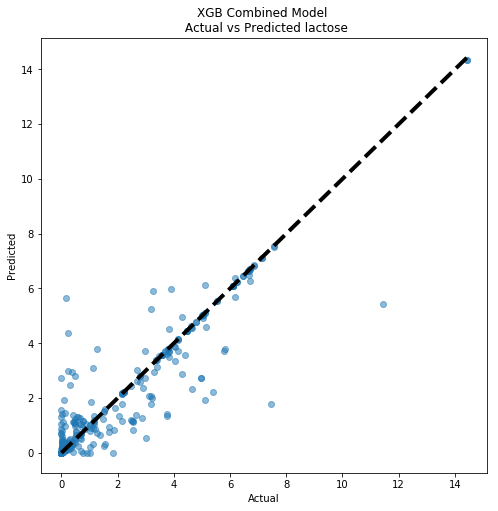

In [20]:
fig, ax = plt.subplots(figsize=[8,8])
ax.scatter(Y, y_pred, alpha=0.5)
ax.plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title('XGB Combined Model \n Actual vs Predicted lactose')
plt.show()

### Plot feature importances

Fit the model to the full dataset

In [21]:
model = XGBCombined(max_depth_reg=9,max_depth_clas=7,importance_type='frequency')
model.fit(X,Y)

XGBCombined(importance_type='frequency', max_depth_clas=7, max_depth_reg=9)

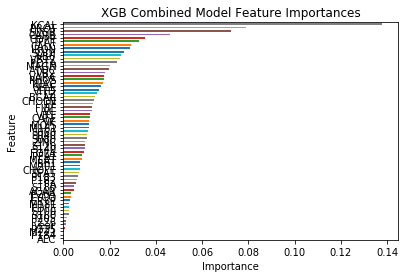

In [22]:
coefficients = pd.DataFrame()
coefficients['Feature'] = X.columns
coefficients['XGB Combined Importance'] = model.reg.feature_importances_
coefficients = coefficients.set_index('Feature')
axs = coefficients.sort_values('XGB Combined Importance').plot.barh(y='XGB Combined Importance')
axs.set_title('XGB Combined Model Feature Importances')
axs.set_xlabel('Importance')
axs.get_legend().remove()

In [26]:
coefficients.to_csv('xgb_combined_coef.csv')

#### Save model to file

In [24]:
with open("../models/xgb_combined.model", "wb" ) as f:
    pkl.dump(model,f)

In [25]:
# with open("../models/xgb_combined.model", "rb" ) as f:
#     model = pkl.load(f)